In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [38]:
# Step 1: Fetch Historical Stock Data
start_date = '2010-01-01'
end_date = '2023-01-01'
adbe_data = yf.download('ADBE', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [39]:
prices = pd.DataFrame({
    'ADBE': adbe_data['Adj Close'],
    'MSFT': msft_data['Adj Close']
})
prices.dropna(inplace=True)
print(prices)

                  ADBE        MSFT
Date                              
2010-01-04   37.090000   23.300680
2010-01-05   37.700001   23.308212
2010-01-06   37.619999   23.165165
2010-01-07   36.889999   22.924255
2010-01-08   36.689999   23.082350
...                ...         ...
2022-12-23  338.450012  234.875443
2022-12-27  335.089996  233.134033
2022-12-28  328.329987  230.743240
2022-12-29  337.579987  237.118607
2022-12-30  336.529999  235.947845

[3272 rows x 2 columns]


In [40]:
# Calculate price ratio
prices['Price_Ratio'] = prices['ADBE'] / prices['MSFT']

# Technical Indicators
prices['5d_MA'] = prices['Price_Ratio'].rolling(window=5).mean()
prices['20d_MA'] = prices['Price_Ratio'].rolling(window=20).mean()
prices['60d_MA'] = prices['Price_Ratio'].rolling(window=60).mean()
prices['ROC'] = prices['Price_Ratio'].pct_change(periods=5)
prices['Volatility'] = prices['Price_Ratio'].rolling(window=20).std()

# Lag features
prices['Lag1'] = prices['Price_Ratio'].shift(1)
prices['Lag2'] = prices['Price_Ratio'].shift(2)
prices.dropna(inplace=True)

In [41]:
# Define features and target
features = ['5d_MA', '20d_MA', '60d_MA', 'ROC', 'Volatility', 'Lag1', 'Lag2']
X = prices[features]
y = prices['Price_Ratio']


In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [44]:
# Perform grid search with cross-validation
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [45]:
# Best model from grid search
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
# Evaluate the model
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0004751360896868283


In [65]:
prices['Predicted_Ratio'] = best_model.predict(prices[features])
prices['Signal'] = 0
prices.loc[prices['Predicted_Ratio'] > prices['Price_Ratio'], 'Signal'] = 1  # Buy Signal
prices.loc[prices['Predicted_Ratio'] < prices['Price_Ratio'], 'Signal'] = -1  # Sell Signal


In [66]:
# Simulate trading by calculating PnL for each trade
prices['PnL'] = 0
for i in range(1, len(prices)):
    if prices.iloc[i]['Signal'] == -1:
        # Buy ADBE and sell MSFT
        pnl_adbe = prices.iloc[i]['ADBE'] - prices.iloc[i - 1]['ADBE']
        pnl_msft = prices.iloc[i - 1]['MSFT'] - prices.iloc[i]['MSFT']
        prices.at[prices.index[i], 'PnL'] = pnl_adbe + pnl_msft
    elif prices.iloc[i]['Signal'] == 1:
        # Sell ADBE and buy MSFT
        pnl_adbe = prices.iloc[i - 1]['ADBE'] - prices.iloc[i]['ADBE']
        pnl_msft = prices.iloc[i]['MSFT'] - prices.iloc[i - 1]['MSFT']
        prices.at[prices.index[i], 'PnL'] = pnl_adbe + pnl_msft

# Calculate cumulative profit and loss
prices['Cumulative_PnL'] = prices['PnL'].cumsum()

C:\Users\Aadit\AppData\Local\Temp\ipykernel_5216\1138976564.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.053050994873046875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prices.at[prices.index[i], 'PnL'] = pnl_adbe + pnl_msft


In [67]:
print(prices)

                  ADBE        MSFT  Price_Ratio     5d_MA    20d_MA    60d_MA  \
Date                                                                            
2010-03-30   35.680000   22.517122     1.584572  1.594520  1.593785  1.569112   
2010-03-31   35.369999   22.154070     1.596546  1.588230  1.592734  1.569191   
2010-04-01   35.740002   22.055735     1.620440  1.596264  1.593081  1.569241   
2010-04-05   35.990002   22.138935     1.625643  1.604819  1.593067  1.569269   
2010-04-06   35.700001   22.176760     1.609793  1.607399  1.592605  1.569278   
...                ...         ...          ...       ...       ...       ...   
2022-12-23  338.450012  234.875443     1.440977  1.421593  1.380684  1.349119   
2022-12-27  335.089996  233.134033     1.437328  1.431117  1.383397  1.353002   
2022-12-28  328.329987  230.743240     1.422924  1.431359  1.385442  1.356589   
2022-12-29  337.579987  237.118607     1.423676  1.432182  1.387920  1.360183   
2022-12-30  336.529999  235.

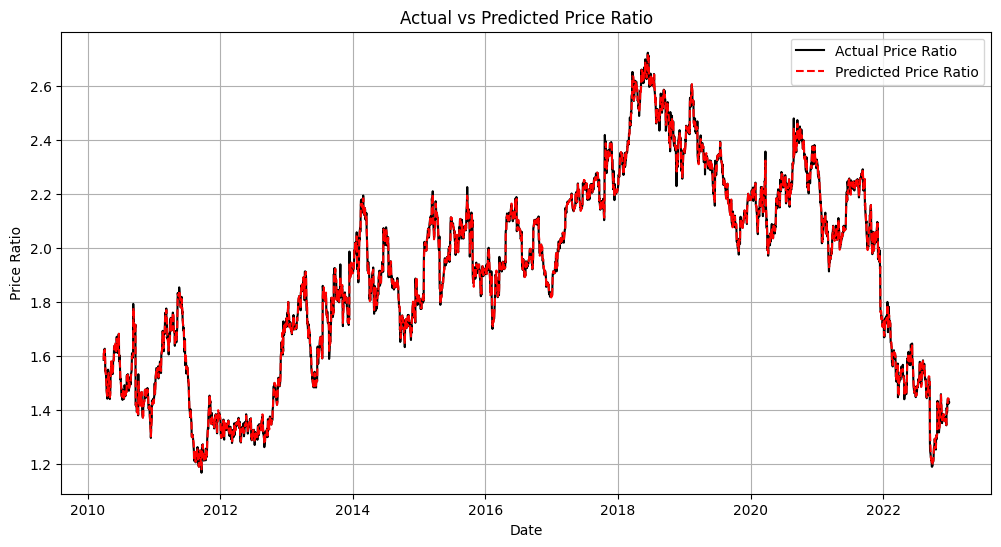

In [68]:

# Plot the actual and predicted price ratios for comparison
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices['Price_Ratio'], label='Actual Price Ratio', color='black')
plt.plot(prices.index, prices['Predicted_Ratio'], label='Predicted Price Ratio', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Price Ratio')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()

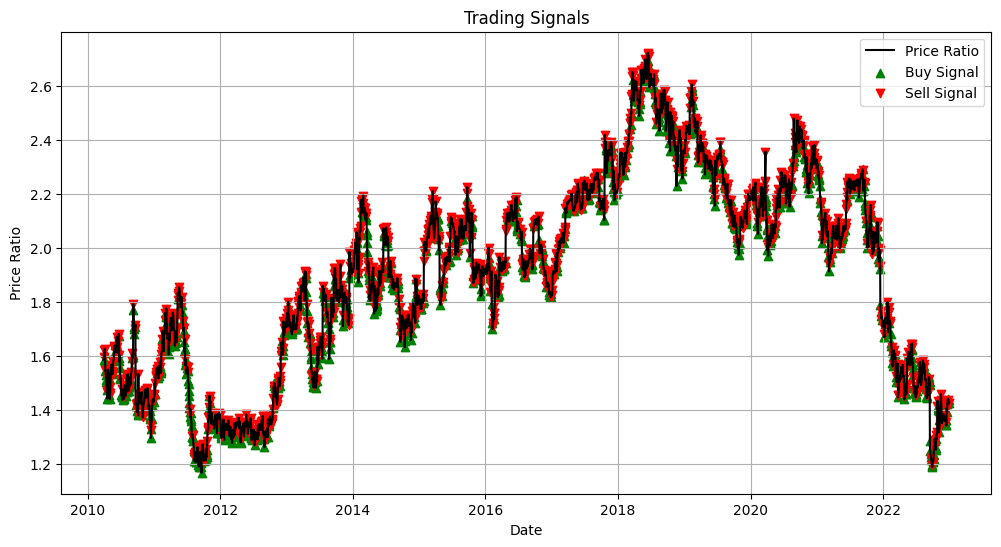

In [69]:
# Plot the trading signals
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices['Price_Ratio'], label='Price Ratio', color='black')
plt.scatter(prices.index[prices['Signal'] == 1], prices['Price_Ratio'][prices['Signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(prices.index[prices['Signal'] == -1], prices['Price_Ratio'][prices['Signal'] == -1], label='Sell Signal', marker='v', color='red')
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price Ratio')
plt.legend()
plt.grid()
plt.show()

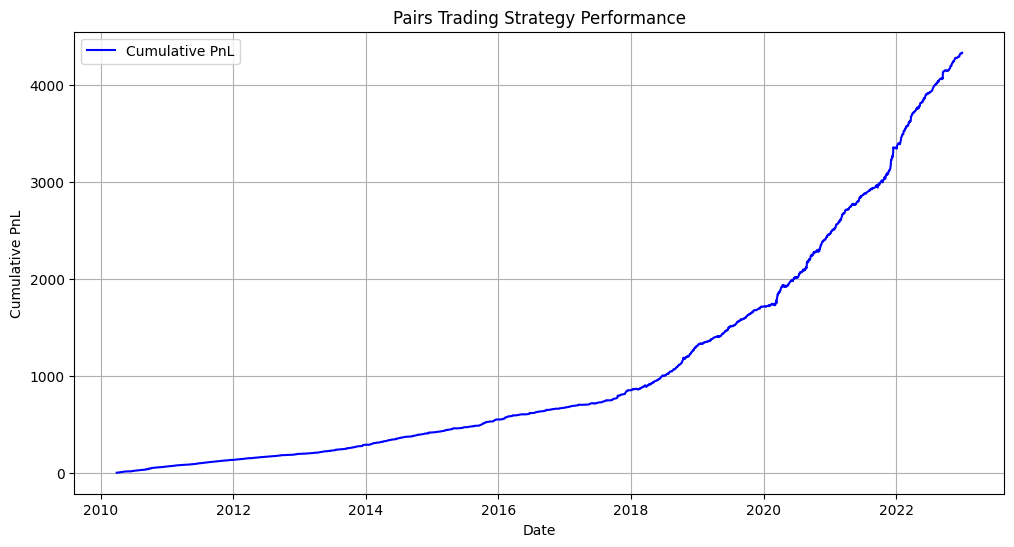

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(prices['Cumulative_PnL'], label='Cumulative PnL', color='blue')
plt.title('Pairs Trading Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid()
plt.show()